<a href="https://colab.research.google.com/github/dileep9968/pytorch/blob/main/06_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.5.1+cu121
0.20.1+cu121
True
12.1


In [2]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision version not as required installing nightly verion")
  !pip install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision version not as required installing nightly verion
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
except:
  print(f"[INFO] Couldn't find going_modular.get_data_loaders()... downloading it.")
  !git clone https://github.com/dileep9968/pytorch
  !mv pytorch/going_modular .
  !rm -rf pytorch
  from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular.get_data_loaders()... downloading it.
Cloning into 'pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 59 (delta 23), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 3.85 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [4]:
# setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [5]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(request.content)
  print(f"Downloaded Successfully {image_path}")
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)
  print(f"Unzpipped Successfully {image_path}")



Did not find data/pizza_steak_sushi directory, creating one...
Downloaded Successfully data/pizza_steak_sushi
Unzipping data...
Unzpipped Successfully data/pizza_steak_sushi


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create dataset and dataloader

In [7]:
from going_modular import data_setup
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225]
                                 )

data_transform  = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor(),
                                      normalize
                                      ])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                                train_dir=train_dir,
                                                test_dir=test_dir,
                                                transform=data_transform,
                                                batch_size=32,
                                                num_workers=os.cpu_count()
                                                )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7904533f5660>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)


In [8]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# GEt the transforms use to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoader using automatric transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                                train_dir=train_dir,
                                                test_dir=test_dir,
                                                transform = auto_transforms,
                                                batch_size=32
                                                )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7904533f5510>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model
1. Pytorch domain librariws
2. timm ( torch image model)
3. Huggingface Hub
4. Paperwithcode

### 3.1 Which pretrained model should you use?
The whole idea of trnasfer learning: take a already well-performing model from a problem space similary to your own and then customize to your own problem

Three things to conider:
1. Speed
2. Size
3. Performance

### 3.2 Setting up a pretrained model

In [11]:
#model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with torchinfo.summary()

In [13]:
from torchinfo import summary

summary(model = model,
        input_size =(1,3,224,224),
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our need

with a feature exactor model, typically you will 'freeze' the base layer os a pretrained model and update the output layer

In [14]:
# Freeze all the base layer in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False


In [15]:

summary(model = model,
        input_size =(1,3,224,224),
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [16]:
# update the classifier head of our model to suit our problem
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:

summary(model = model,
        input_size =(1,3,224,224),
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [32]:
# import train model
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()
results=engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=5,
             device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2220 | train_acc: 0.9805 | test_loss: 0.3858 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.2127 | train_acc: 0.9844 | test_loss: 0.3620 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.2079 | train_acc: 0.9805 | test_loss: 0.3712 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.2234 | train_acc: 0.9961 | test_loss: 0.3577 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.1864 | train_acc: 0.9883 | test_loss: 0.3780 | test_acc: 0.8456
[INFO] Total training time: 12.37594363400001 seconds


In [30]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find plot_loss_curves()... downloading it.")
  import requests
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

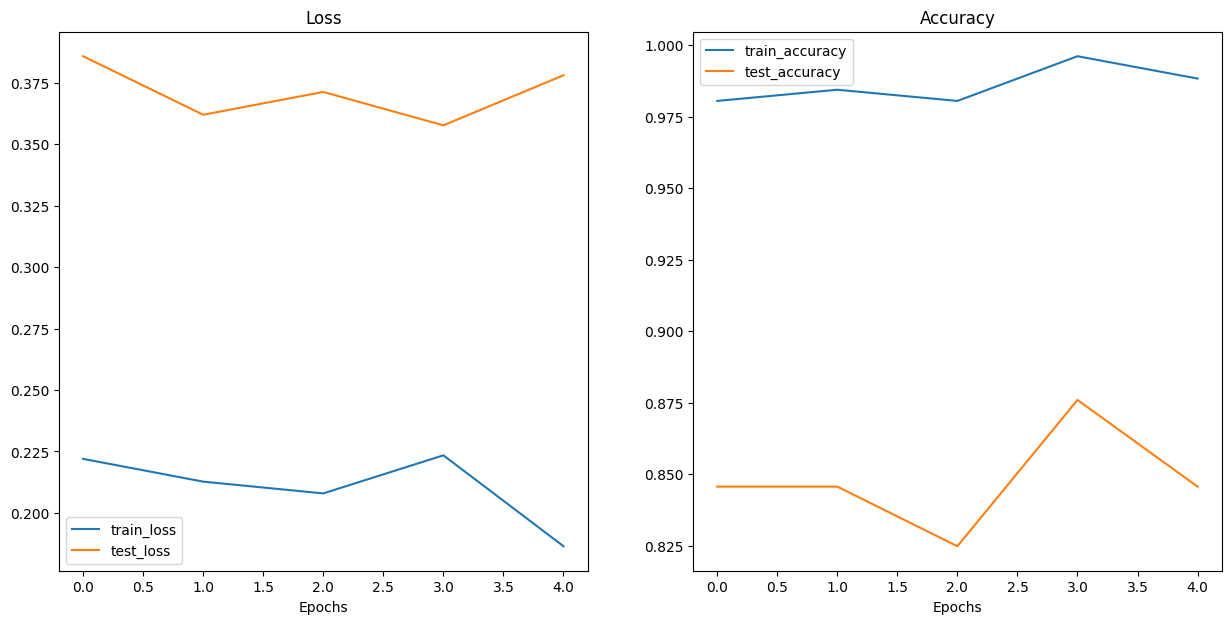

In [33]:
plot_loss_curves(results)

## 6. Make prediction on image from the test set

In [34]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform: torchvision.transforms = None,
                        image_size: Tuple[int, int] = (224, 224),
                        device: torch.device = device):
  img = Image.open(image_path)

  if transform is not None:
    img = transform(img)
  else:
    image_transforms = transforms.Compose([
                                            transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
                                           ])


  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transforms(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}")
  plt.axis(False)
#

In [44]:
import random
num_images_to_plot=3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, num_images_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg')]

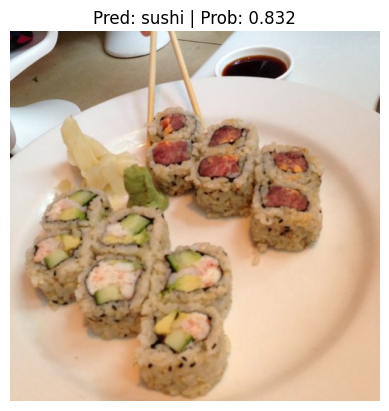

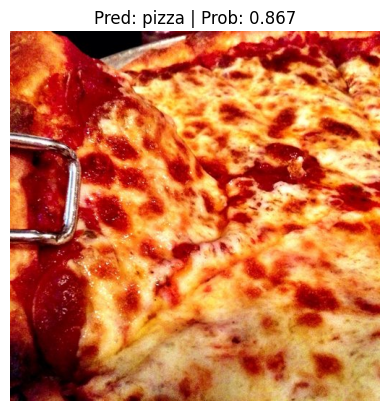

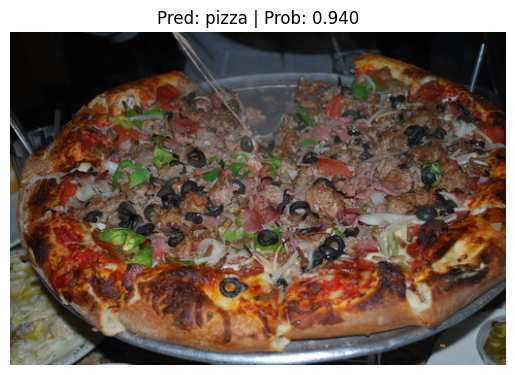

In [45]:
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224),
                      device=device)
#